<a href="https://colab.research.google.com/github/kagbobidi/SIT-feedback-stability/blob/main/robustest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

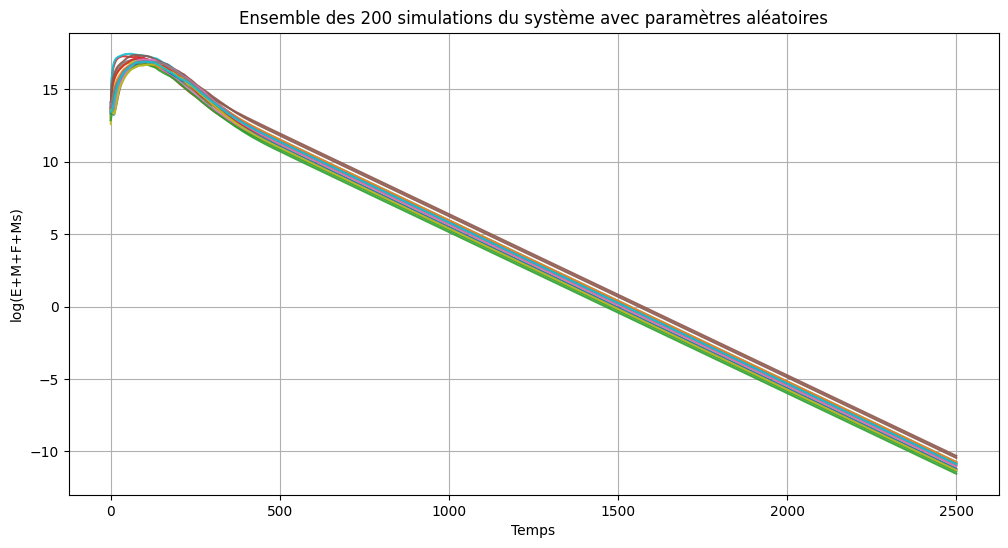

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres (à ajuster selon ton modèle)
beta_E = 8.0
K = 222000.0
nu_E = 0.1275
delta_E = 0.04
delta_M = 0.1
delta_F = 0.04
delta_s = 0.12
nu = 0.49



theta = 220
alpha = 90
gamma_s = 1
beta_s = 1

R_0 = beta_E*nu*nu_E/(delta_F*(nu_E+delta_E))

R_theta = R_0/(1+gamma_s*theta)

psi = 2*beta_E*nu*nu_E/(delta_F*(1-R_theta)*(1+gamma_s*theta))

#Perturbation
def random_params():
    hbeta_E = np.random.uniform(7.46, 14.85)
    hnu_E   = np.random.uniform(0.005, 0.25)
    hdelta_E = np.random.uniform(0.023, 0.046)
    hdelta_F = np.random.uniform(0.033, 0.046)
    hdelta_M = np.random.uniform(0.077, 0.139)
    return hbeta_E, hnu_E, hdelta_E, hdelta_F, hdelta_M

# Fonction contrôle u(t) (exemple : constant)
def u(E, M, Ms):
    # Petites constantes pour éviter division par zéro


    term1 = (gamma_s * psi * E * (theta*M + Ms)**2) / (
        alpha * (M + gamma_s*Ms) * (3*theta*M + Ms)
    )

    term2 = (((1-nu)*nu_E*theta*E - theta*delta_M*M) * (theta*M + 3*Ms)) / (
        3*theta*M + Ms
    )

    term3 = delta_s * Ms
    term4 = (beta_s/alpha) * (theta*M - Ms)

    Term = max(0,term1 + term2 + term3 + term4)

    return Term

# Schéma d'Euler
def euler_system(T=2000, dt=0.1,E0=50, M0=20, F0=20, Ms0=10):
    N = int(T/dt)
    t = np.linspace(0, T, N+1)

    # Variables : E, M, F, Ms
    E = np.zeros(N+1)
    M = np.zeros(N+1)
    F = np.zeros(N+1)
    Ms = np.zeros(N+1)

    # Conditions initiales
    E[0], M[0], F[0], Ms[0] = E0, M0, F0, Ms0

    # Boucle temporelle
    for n in range(N):
        En, Mn, Fn, Msn = E[n], M[n], F[n], Ms[n]
        hbeta_E, hnu_E, hdelta_E, hdelta_F, hdelta_M = random_params()


        # Équations différentielles
        dE = hbeta_E * Fn * (1 - En/K) - (hnu_E + hdelta_E) * En
        dM = (1-nu) * hnu_E * En - hdelta_M * Mn
        dF = nu * hnu_E * En * (Mn / (Mn + gamma_s * Msn)) - hdelta_F * Fn  # +1e-9 pour éviter division par 0
        dMs = u(En, Mn, Msn) - delta_s * Msn

        # Mise à jour (Euler explicite)
        E[n+1] = En + dt * dE
        M[n+1] = Mn + dt * dM
        F[n+1] = Fn + dt * dF
        Ms[n+1] = Msn + dt * dMs



    return t, E, M, F, Ms

num_sim = 20
T = 2500
dt = 0.1
#colors = plt.cm.viridis(np.linspace(0, 1, num_sim))


plt.figure(figsize=(12,6))

for i in range(num_sim):
    # Conditions initiales strictement positives et E0<K
    E0 = np.random.uniform(1, K-1)
    M0 = np.random.uniform(1, 2*K)
    F0 = np.random.uniform(1, 2*K)
    Ms0 = np.random.uniform(1, 2*K)

    t, E, M, F, Ms = euler_system(T=T, dt=dt, E0=E0, M0=M0, F0=F0, Ms0=Ms0)

    # Affichage de la somme des populations en log
    color = np.random.rand(3,)

    plt.plot(t, np.log(E+M+F+Ms), alpha=0.9)


plt.xlabel("Temps")
plt.ylabel("log(E+M+F+Ms)")
plt.title("Ensemble des 200 simulations du système avec paramètres aléatoires")
plt.grid(True)
plt.show()